# (CSE 430) Introduction to Neuroscience Final Project

#### Muhammed ÇINAKLI - 161805027

## Dataset Introduction

### DJIA 30 Stock Time Series
Historical stock data for DIJA 30 companies (2006-01-01 to 2018-01-01)

Link: https://www.kaggle.com/szrlee/stock-time-series-20050101-to-20171231


### Content
The data is presented in a couple of formats to suit different individual's needs or computational limitations.
I have included files containing 13 years of stock data (in the allstocks2006-01-01to2018-01-01.csv and corresponding folder) and
a smaller version of the dataset (allstocks2017-01-01to2018-01-01.csv) with only the past year's stock data for those wishing to use something more manageable in size.

The folder individualstocks2006-01-01to2018-01-01 contains files of data for individual stocks, labelled by their stock ticker name.
The allstocks2006-01-01to2018-01-01.csv and allstocks2017-01-01to2018-01-01.csv contain this same data, presented in merged .csv files.
Depending on the intended use (graphing, modelling etc.) the user may prefer one of these given formats.

All the files have the following columns:

Date - in format: yy-mm-dd

Open - price of the stock at market open (this is NYSE data so all in USD)

High - Highest price reached in the day

Low Close - Lowest price reached in the day

Volume - Number of shares traded

Name - the stock's ticker name

##### Let's checking the gpu

In [1]:
import tensorflow as tf
from tensorflow.python.client import device_lib
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 10060024935866306472,
 name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 13113043518314138660
 physical_device_desc: "device: XLA_CPU device",
 name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 3475263870970040662
 physical_device_desc: "device: XLA_GPU device",
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 3658088448
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 7351959422506572844
 physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 950M, pci bus id: 0000:01:00.0, compute capability: 5.0"]

In [3]:
tf.test.is_built_with_cuda()

True

## Reading and Understanding the Data

In [4]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight') 
%matplotlib inline
from sklearn.metrics import mean_squared_error
from math import sqrt
from keras.optimizers import SGD,Adam
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional

In [5]:
dataset = pd.read_csv("dataset/all_stocks_2006-01-01_to_2018-01-01.csv", index_col="Date")

In [6]:
print(dataset.shape)

(93612, 6)


In [7]:
print(dataset.Name.unique())

['MMM' 'AXP' 'AAPL' 'BA' 'CAT' 'CVX' 'CSCO' 'KO' 'DIS' 'XOM' 'GE' 'GS'
 'HD' 'IBM' 'INTC' 'JNJ' 'JPM' 'MCD' 'MRK' 'MSFT' 'NKE' 'PFE' 'PG' 'TRV'
 'UTX' 'UNH' 'VZ' 'WMT' 'GOOGL' 'AMZN' 'AABA']


There are lots of companies in the dataset. I will just analyze five of them: Microsoft, Google, Apple, Amazon, Ibm.

In [8]:
microsoft = dataset[dataset['Name']=='MSFT']
google = dataset[dataset['Name']=='GOOGL']
apple = dataset[dataset['Name']=='AAPL']
amazon = dataset[dataset['Name']=='AMZN']
ibm = dataset[dataset['Name']=='IBM']

## Data Preprocessing

In [9]:
print(dataset.duplicated().sum())

0


There aren't any duplicated values in the dataset.

In [10]:
stocks = [microsoft, google, apple, amazon, ibm]
for i in stocks:
    print('\033[1mNULL VALUES\033[0m\n'+ str(i.isnull().sum()))

NULL VALUES
Open      0
High      0
Low       0
Close     0
Volume    0
Name      0
dtype: int64
NULL VALUES
Open      0
High      0
Low       0
Close     0
Volume    0
Name      0
dtype: int64
NULL VALUES
Open      0
High      0
Low       0
Close     0
Volume    0
Name      0
dtype: int64
NULL VALUES
Open      0
High      0
Low       0
Close     0
Volume    0
Name      0
dtype: int64
NULL VALUES
Open      1
High      0
Low       1
Close     0
Volume    0
Name      0
dtype: int64


There are some null values in ibm dataset. I will use fill method. ‘fill’ stands for ‘forward fill’ and will propagate last valid observation forward. In this way, last stock value will fill the null value.

In [11]:
ibm.fillna(method='ffill', inplace=True)

In [12]:
print(ibm.isnull().sum().any())

False


## Exploratory Data Analysis

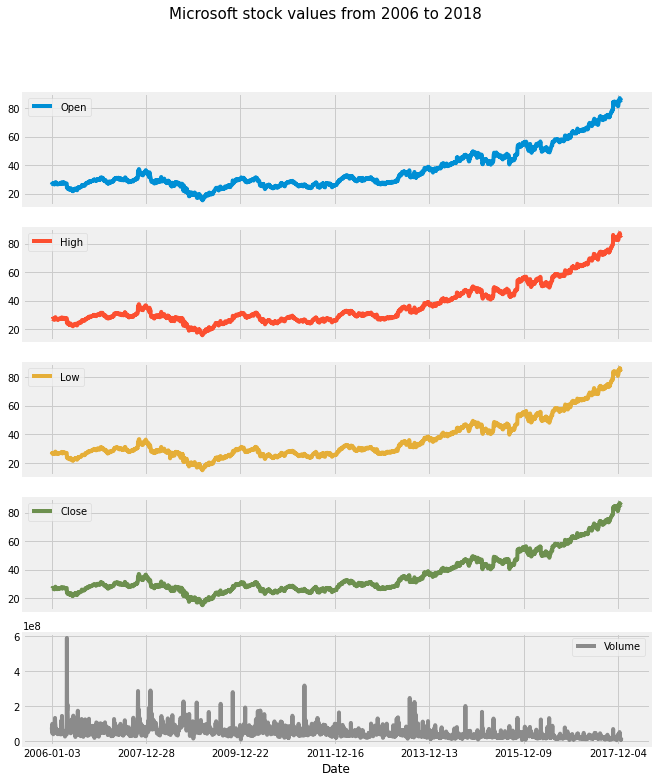

In [13]:
microsoft.plot(subplots=True, figsize=(10,12))
plt.suptitle('Microsoft stock values from 2006 to 2018', fontsize=15)
plt.show()

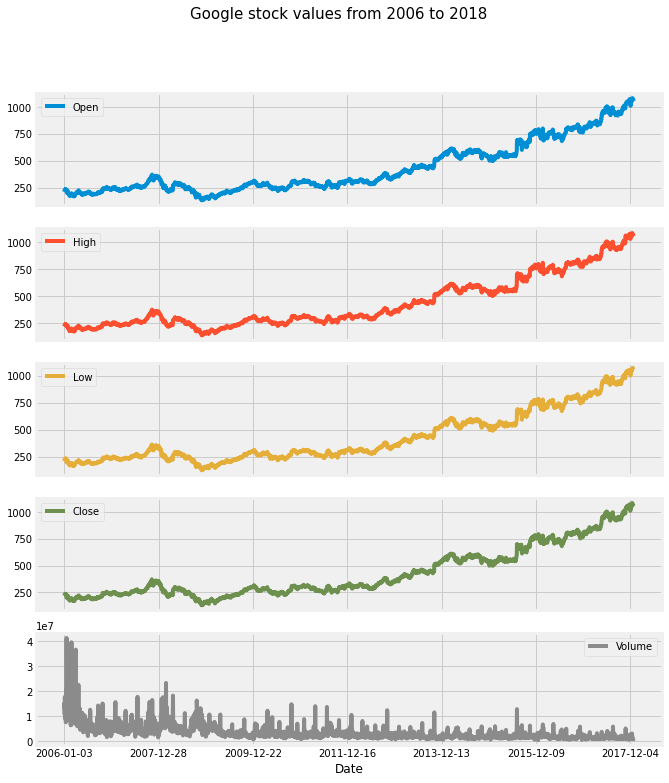

In [14]:
google.plot(subplots=True, figsize=(10,12))
plt.suptitle('Google stock values from 2006 to 2018', fontsize=15)
plt.show()

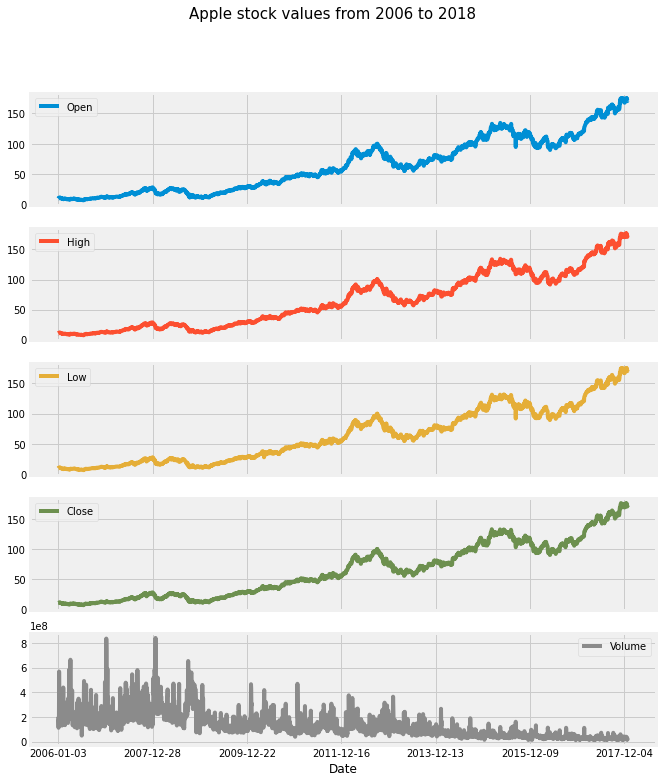

In [15]:
apple.plot(subplots=True, figsize=(10,12))
plt.suptitle('Apple stock values from 2006 to 2018', fontsize=15)
plt.show()

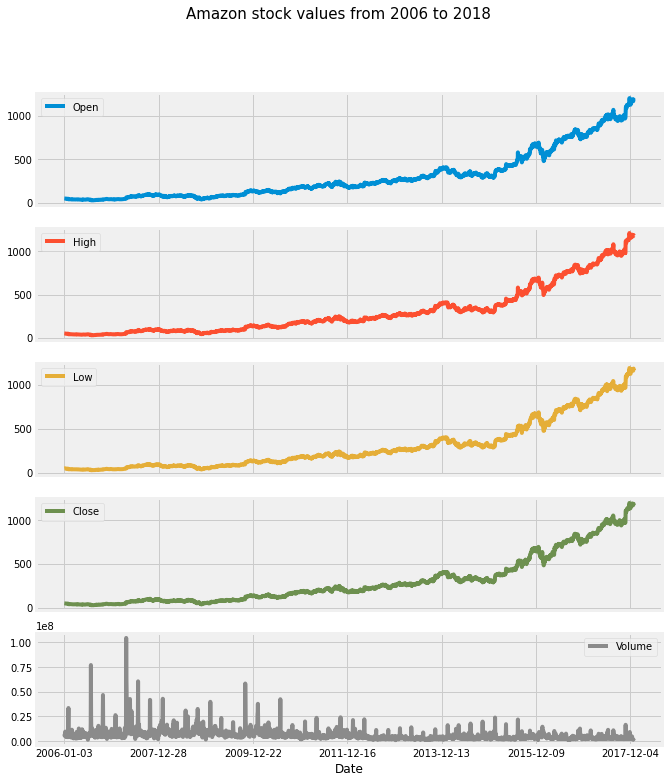

In [16]:
amazon.plot(subplots=True, figsize=(10,12))
plt.suptitle('Amazon stock values from 2006 to 2018', fontsize=15)
plt.show()

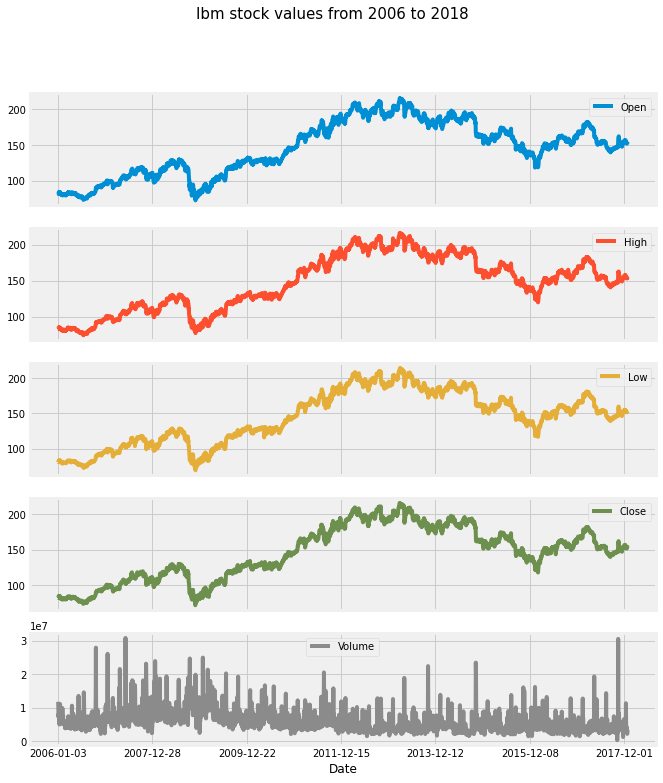

In [17]:
ibm.plot(subplots=True, figsize=(10,12))
plt.suptitle('Ibm stock values from 2006 to 2018', fontsize=15)
plt.show()

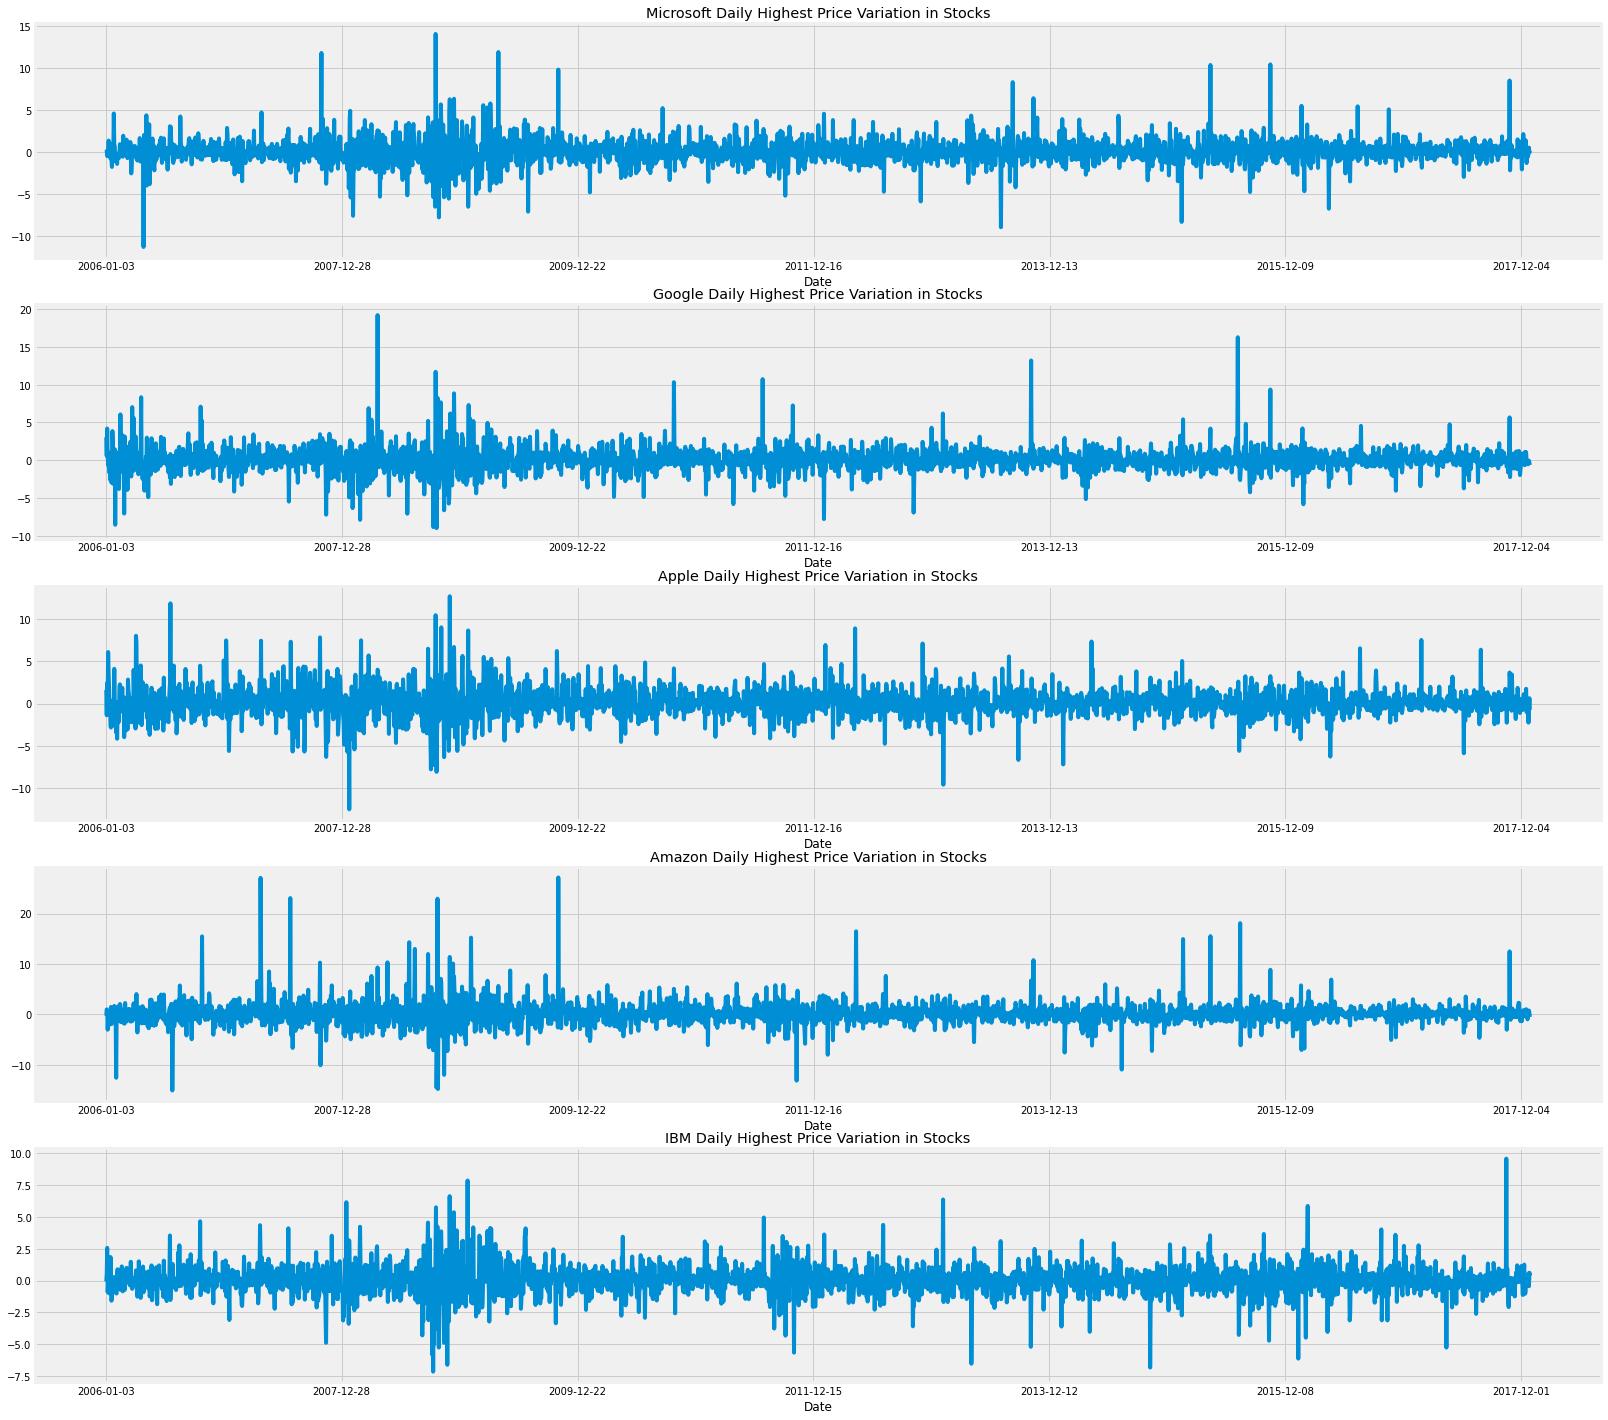

In [18]:
plt.figure(figsize=(25,25))

plt.subplot(5,1,1)
microsoft.High.pct_change().mul(100).plot()
plt.title("Microsoft Daily Highest Price Variation in Stocks")

plt.subplot(5,1,2)
google.High.pct_change().mul(100).plot()
plt.title("Google Daily Highest Price Variation in Stocks")

plt.subplot(5,1,3)
apple.High.pct_change().mul(100).plot()
plt.title("Apple Daily Highest Price Variation in Stocks")

plt.subplot(5,1,4)
amazon.High.pct_change().mul(100).plot()
plt.title("Amazon Daily Highest Price Variation in Stocks")

plt.subplot(5,1,5)
ibm.High.pct_change().mul(100).plot()
plt.title("IBM Daily Highest Price Variation in Stocks")

plt.show()

The graph above show the price variation in stocks for all the companies comparing the price values for two consequtive days. There are high price changes during 2008 financial crisis period.

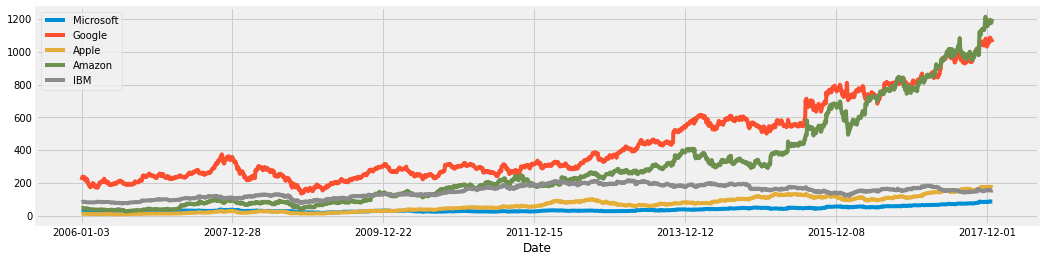

In [19]:
microsoft["High"].plot(figsize=(16,4),legend=True)
google["High"].plot(figsize=(16,4),legend=True)
apple["High"].plot(figsize=(16,4),legend=True)
amazon["High"].plot(figsize=(16,4),legend=True)
ibm["High"].plot(figsize=(16,4),legend=True)
plt.legend(['Microsoft','Google', 'Apple', 'Amazon', 'IBM'])
plt.show()

Google and Amazon's stock prices are significantly higher than Apple, IBM, and Microsoft.

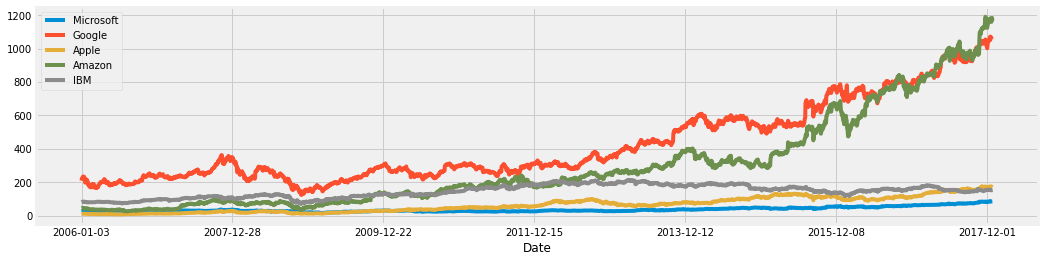

In [20]:
microsoft["Low"].plot(figsize=(16,4),legend=True)
google["Low"].plot(figsize=(16,4),legend=True)
apple["Low"].plot(figsize=(16,4),legend=True)
amazon["Low"].plot(figsize=(16,4),legend=True)
ibm["Low"].plot(figsize=(16,4),legend=True)
plt.legend(['Microsoft','Google', 'Apple', 'Amazon', 'IBM'])
plt.show()

## Data Preparation

### Splitting the Dataset

We will split the dataset as train and test sets. Train set include the period that shows the highest stock prices until 2016. Test set include the period starting from 2016 and ends in 2018.

In [21]:
def split(data):
    return data[:'2016'].iloc[:, 1:2].values, data['2016':].iloc[:,1:2].values

microsoft_train, microsoft_test = split(microsoft)
google_train, google_test = split(google)
apple_train, apple_test = split(apple)
amazon_train, amazon_test = split(amazon)
ibm_train, ibm_test = split(ibm)

In [22]:
print("\033[1mShapes of train and test sets\033[0m\n")
print("Microsoft train set:", microsoft_train.shape, "Microsoft test set:", microsoft_test.shape)
print("Google train set:", google_train.shape, "Google test set:", google_test.shape)
print("Apple train set:", apple_train.shape, "Apple test set:", apple_test.shape)
print("Amazon train set:", amazon_train.shape, "Amazon test set:", amazon_test.shape)
print("IBM train set:", ibm_train.shape, "IBM test set:", ibm_test.shape)

Shapes of train and test sets

Microsoft train set: (2516, 1) Microsoft test set: (503, 1)
Google train set: (2516, 1) Google test set: (503, 1)
Apple train set: (2516, 1) Apple test set: (503, 1)
Amazon train set: (2516, 1) Amazon test set: (503, 1)
IBM train set: (2517, 1) IBM test set: (503, 1)


### Scaling the Data

We have to scale our data for optimal performance. When evaluating stock prices, we’ll use Scikit-Learn’s MinMaxScaler and scale our dataset to numbers between zero and one.

In [23]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
microsoft_train_scaled, microsoft_test_scaled = sc.fit_transform(microsoft_train), sc.fit_transform(microsoft_test)
google_train_scaled, google_test_scaled = sc.fit_transform(google_train), sc.fit_transform(google_test)
apple_train_scaled, apple_test_scaled = sc.fit_transform(apple_train), sc.fit_transform(apple_test)
amazon_train_scaled, amazon_test_scaled = sc.fit_transform(amazon_train), sc.fit_transform(amazon_test)
ibm_train_scaled, ibm_test_scaled = sc.fit_transform(ibm_train), sc.fit_transform(ibm_test)

## Training with LSTM

We will apply "Many to One" LSTM model. We will create a structure that contains 60 timesteps and 1 output.

The model expect the data to be in the shape "samples, timesteps, features". That's why we change the shape of training set.

NOTE:

Samples - This is the len(data), or the amount of data points you have.

Time steps - This is equivalent to the amount of time steps you run your recurrent neural network. If you want your network to have memory of 60 characters, this number should be 60.

Features - this is the amount of features in every time step. If you are processing pictures, this is the amount of pixels. In this case you seem to have 1 feature per time step.



#### For train:

In [24]:
train_map = {"microsoft": microsoft_train_scaled, "google": google_train_scaled, "apple": apple_train_scaled, "amazon": amazon_train_scaled, "ibm": ibm_train_scaled}
train_map_X = {"microsoft": [], "google": [], "apple": [], "amazon": [], "ibm": []}
train_map_y = {"microsoft": [], "google": [], "apple": [], "amazon": [], "ibm": []}

for key in train_map.keys():
    for i in range(60,2516):   
        train_map_X[key].append(train_map[key][i-60:i,0])
        train_map_y[key].append(train_map[key][i, 0])
    train_map_X[key], train_map_y[key] = np.array(train_map_X[key]), np.array(train_map_y[key])
    train_map_X[key] = np.reshape(train_map_X[key], (train_map_X[key].shape[0],train_map_X[key].shape[1],1))

#### For test:

In [25]:
test_map = {"microsoft": microsoft_test_scaled, "google": google_test_scaled, "apple": apple_test_scaled, "amazon": amazon_test_scaled, "ibm": ibm_test_scaled}
test_map_X = {"microsoft": [], "google": [], "apple": [], "amazon": [], "ibm": []}
test_map_y = {"microsoft": [], "google": [], "apple": [], "amazon": [], "ibm": []}

for key in test_map.keys():
    for i in range(60,503):
        test_map_X[key].append(test_map[key][i-60:i,0])
        test_map_y[key].append(test_map[key][i, 0])
    test_map_X[key], test_map_y[key]= np.array(test_map_X[key]), np.array(test_map_y[key])
    test_map_X[key] = np.reshape(test_map_X[key], (test_map_X[key].shape[0], test_map_X[key].shape[1], 1))

Firstly, we create base lstm and then we will improve step by step our lstm model. Also we will test for microsoft stock prices, then we will apply it to other stock prices.

In [32]:
lstm = Sequential()
lstm.add(LSTM(units=32,return_sequences=True, input_shape=(train_map_X["microsoft"].shape[1],1)))
lstm.add(LSTM(units=32,return_sequences=True))
lstm.add(LSTM(units=32,return_sequences=True))
lstm.add(LSTM(units=32))
lstm.add(Dense(units=1))

# Compiling the RNN
lstm.compile(optimizer='rmsprop',loss='mean_squared_error')

# Fitting to the training set
print("Training:", "microsoft")
history = lstm.fit(train_map_X["microsoft"],train_map_y["microsoft"],epochs=20,batch_size=32,verbose=1,validation_split=0.2)

Training: microsoft
Epoch 1/20
62/62 [==============================] - 2s 39ms/step - loss: 0.0059 - val_loss: 0.0038
Epoch 2/20
62/62 [==============================] - 1s 23ms/step - loss: 0.0027 - val_loss: 0.0040
Epoch 3/20
62/62 [==============================] - 1s 23ms/step - loss: 0.0021 - val_loss: 0.0066
Epoch 4/20
62/62 [==============================] - 1s 23ms/step - loss: 0.0018 - val_loss: 0.0048
Epoch 5/20
62/62 [==============================] - 1s 23ms/step - loss: 0.0015 - val_loss: 0.0068
Epoch 6/20
62/62 [==============================] - 1s 23ms/step - loss: 0.0012 - val_loss: 0.0377
Epoch 7/20
62/62 [==============================] - 1s 23ms/step - loss: 0.0012 - val_loss: 0.0016
Epoch 8/20
62/62 [==============================] - 1s 23ms/step - loss: 0.0012 - val_loss: 0.0040
Epoch 9/20
62/62 [==============================] - 1s 23ms/step - loss: 9.1237e-04 - val_loss: 0.0118
Epoch 10/20
62/62 [==============================] - 1s 22ms/step - loss: 8.4640e-04 

Defining plotting function for loss values and prediction

In [27]:
def plot(y_true, y_prediction):
    plt.plot(y_true, color='red', label='Actual Stock Prices')
    plt.plot(y_prediction, color='blue', label='Predicted Stock Prices')
    plt.title(str.capitalize("microsoft"))
    plt.xlabel('Time')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()

In [28]:
def plot_los(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model train vs validation loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()

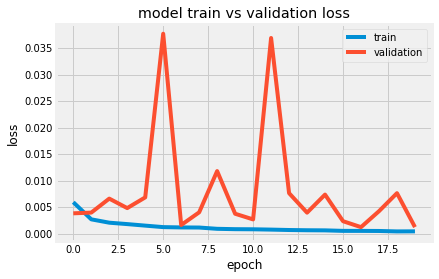

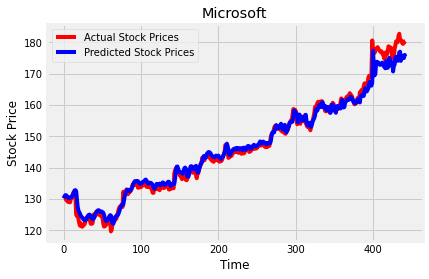

Microsoft Root Mean Squared Error: 2.0938675674297214


In [33]:
y_true = sc.inverse_transform(test_map_y["microsoft"].reshape(-1,1)) 
y_prediction = sc.inverse_transform(lstm.predict(test_map_X["microsoft"])) 
plot_los(history)
plot(y_true, y_prediction)
rmse = sqrt(mean_squared_error(y_true, y_prediction))
print(str.capitalize("microsoft"), "Root Mean Squared Error:", rmse)

As seen in the graph, our model has overfitted. In our new model, instead of adding lstm units piece by piece, we will try to add them together, then we will add a dropout layer to prevent overfitting.

In [34]:
lstm = Sequential()
lstm.add(LSTM(units=96, return_sequences=True, input_shape=(train_map_X["microsoft"].shape[1],1)))
lstm.add(LSTM(units=32))
lstm.add(Dense(units=1))

# Compiling the RNN
lstm.compile(optimizer='rmsprop',loss='mean_squared_error')

# Fitting to the training set
print("Training:", "microsoft")
history = lstm.fit(train_map_X["microsoft"],train_map_y["microsoft"],epochs=20,batch_size=32,verbose=1,validation_split=0.2)

Training: microsoft
Epoch 1/20
62/62 [==============================] - 1s 19ms/step - loss: 0.0046 - val_loss: 0.0109
Epoch 2/20
62/62 [==============================] - 1s 12ms/step - loss: 0.0014 - val_loss: 0.0011
Epoch 3/20
62/62 [==============================] - 1s 12ms/step - loss: 0.0012 - val_loss: 0.0080
Epoch 4/20
62/62 [==============================] - 1s 12ms/step - loss: 9.2320e-04 - val_loss: 0.0011
Epoch 5/20
62/62 [==============================] - 1s 12ms/step - loss: 7.7835e-04 - val_loss: 0.0027
Epoch 6/20
62/62 [==============================] - 1s 12ms/step - loss: 7.1276e-04 - val_loss: 0.0012
Epoch 7/20
62/62 [==============================] - 1s 12ms/step - loss: 5.6175e-04 - val_loss: 0.0052
Epoch 8/20
62/62 [==============================] - 1s 12ms/step - loss: 5.4686e-04 - val_loss: 0.0089
Epoch 9/20
62/62 [==============================] - 1s 12ms/step - loss: 5.1788e-04 - val_loss: 0.0046
Epoch 10/20
62/62 [==============================] - 1s 12ms/step

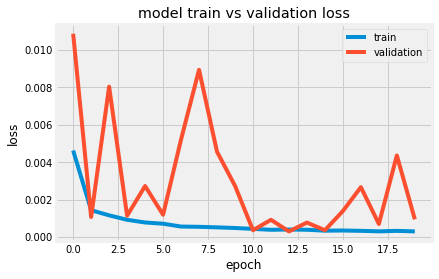

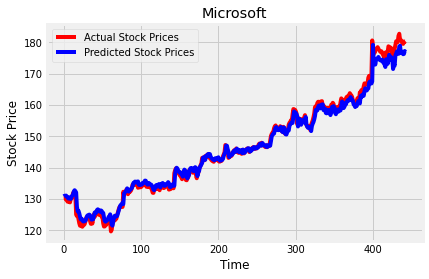

Microsoft Root Mean Squared Error: 1.6905829500866234


In [35]:
y_true = sc.inverse_transform(test_map_y["microsoft"].reshape(-1,1)) 
y_prediction = sc.inverse_transform(lstm.predict(test_map_X["microsoft"])) 
plot_los(history)
plot(y_true, y_prediction)
rmse = sqrt(mean_squared_error(y_true, y_prediction))
print(str.capitalize("microsoft"), "Root Mean Squared Error:", rmse)

we got a better result.

### Adding Dropout for Overfitting

In [36]:
lstm = Sequential()
lstm.add(LSTM(units=96, return_sequences=True, input_shape=(train_map_X["microsoft"].shape[1],1)))
lstm.add(Dropout(0.2))
lstm.add(LSTM(units=32))
lstm.add(Dropout(0.2))
lstm.add(Dense(units=1))

# Compiling the RNN
lstm.compile(optimizer='rmsprop',loss='mean_squared_error')

# Fitting to the training set
print("Training:", "microsoft")
history = lstm.fit(train_map_X["microsoft"],train_map_y["microsoft"],epochs=20,batch_size=32,verbose=1,validation_split=0.2)

Training: microsoft
Epoch 1/20
62/62 [==============================] - 1s 20ms/step - loss: 0.0065 - val_loss: 0.0119
Epoch 2/20
62/62 [==============================] - 1s 13ms/step - loss: 0.0028 - val_loss: 0.0011
Epoch 3/20
62/62 [==============================] - 1s 12ms/step - loss: 0.0021 - val_loss: 0.0076
Epoch 4/20
62/62 [==============================] - 1s 12ms/step - loss: 0.0020 - val_loss: 0.0128
Epoch 5/20
62/62 [==============================] - 1s 12ms/step - loss: 0.0017 - val_loss: 0.0068
Epoch 6/20
62/62 [==============================] - 1s 12ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 7/20
62/62 [==============================] - 1s 12ms/step - loss: 0.0015 - val_loss: 0.0064
Epoch 8/20
62/62 [==============================] - 1s 13ms/step - loss: 0.0013 - val_loss: 0.0131
Epoch 9/20
62/62 [==============================] - 1s 13ms/step - loss: 0.0012 - val_loss: 0.0015
Epoch 10/20
62/62 [==============================] - 1s 13ms/step - loss: 0.0011 - val_lo

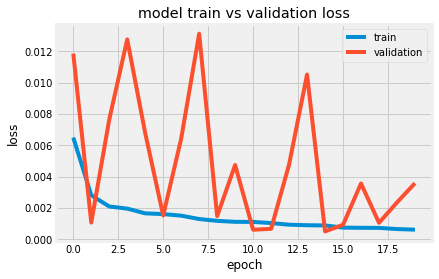

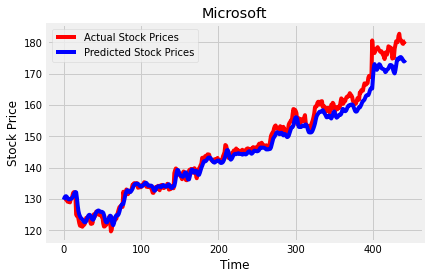

Microsoft Root Mean Squared Error: 2.7614887858669492


In [37]:
y_true = sc.inverse_transform(test_map_y["microsoft"].reshape(-1,1)) 
y_prediction = sc.inverse_transform(lstm.predict(test_map_X["microsoft"])) 
plot_los(history)
plot(y_true, y_prediction)
rmse = sqrt(mean_squared_error(y_true, y_prediction))
print(str.capitalize("microsoft"), "Root Mean Squared Error:", rmse)

let's add more lstm units and see the effect on the result.

In [38]:
lstm = Sequential()
lstm.add(LSTM(units=150, return_sequences=True, input_shape=(train_map_X["microsoft"].shape[1],1)))
lstm.add(Dropout(0.2))
lstm.add(LSTM(units=50))
lstm.add(Dropout(0.2))
lstm.add(Dense(units=1))

# Compiling the RNN
lstm.compile(optimizer='rmsprop',loss='mean_squared_error')

# Fitting to the training set
print("Training:", "microsoft")
history = lstm.fit(train_map_X["microsoft"],train_map_y["microsoft"],epochs=20,batch_size=32,verbose=1,validation_split=0.2)

Training: microsoft
Epoch 1/20
62/62 [==============================] - 1s 23ms/step - loss: 0.0054 - val_loss: 0.0140
Epoch 2/20
62/62 [==============================] - 1s 16ms/step - loss: 0.0025 - val_loss: 0.0025
Epoch 3/20
62/62 [==============================] - 1s 16ms/step - loss: 0.0020 - val_loss: 0.0193
Epoch 4/20
62/62 [==============================] - 1s 16ms/step - loss: 0.0016 - val_loss: 0.0044
Epoch 5/20
62/62 [==============================] - 1s 16ms/step - loss: 0.0014 - val_loss: 6.9406e-04
Epoch 6/20
62/62 [==============================] - 1s 16ms/step - loss: 0.0014 - val_loss: 0.0102
Epoch 7/20
62/62 [==============================] - 1s 16ms/step - loss: 0.0014 - val_loss: 8.8504e-04
Epoch 8/20
62/62 [==============================] - 1s 16ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 9/20
62/62 [==============================] - 1s 18ms/step - loss: 0.0011 - val_loss: 0.0153
Epoch 10/20
62/62 [==============================] - 1s 18ms/step - loss: 0.0010 

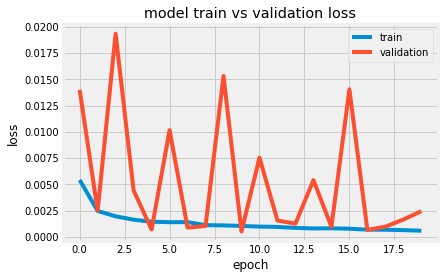

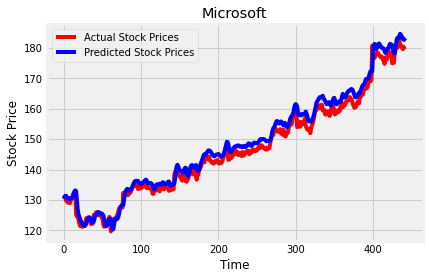

Microsoft Root Mean Squared Error: 2.418145449574913


In [39]:
y_true = sc.inverse_transform(test_map_y["microsoft"].reshape(-1,1)) 
y_prediction = sc.inverse_transform(lstm.predict(test_map_X["microsoft"])) 
plot_los(history)
plot(y_true, y_prediction)
rmse = sqrt(mean_squared_error(y_true, y_prediction))
print(str.capitalize("microsoft"), "Root Mean Squared Error:", rmse)

We had a worse result so we will continue with the previous model and make different changes.

let's change the optimizer parameters.

In [40]:
from keras.optimizers import RMSprop
lstm = Sequential()
lstm.add(LSTM(units=96, return_sequences=True, input_shape=(train_map_X["microsoft"].shape[1],1)))
lstm.add(Dropout(0.2))
lstm.add(LSTM(units=32))
lstm.add(Dropout(0.2))
lstm.add(Dense(units=1))

opt = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

lstm.compile(optimizer=opt,loss='mean_squared_error')

# Fitting to the training set
print("Training:", "microsoft")
history = lstm.fit(train_map_X["microsoft"],train_map_y["microsoft"],epochs=30,batch_size=32,verbose=1,validation_split=0.2)

Training: microsoft
Epoch 1/30
62/62 [==============================] - 1s 19ms/step - loss: 0.0052 - val_loss: 0.0161
Epoch 2/30
62/62 [==============================] - 1s 12ms/step - loss: 0.0025 - val_loss: 0.0050
Epoch 3/30
62/62 [==============================] - 1s 12ms/step - loss: 0.0021 - val_loss: 8.8437e-04
Epoch 4/30
62/62 [==============================] - 1s 12ms/step - loss: 0.0018 - val_loss: 0.0183
Epoch 5/30
62/62 [==============================] - 1s 12ms/step - loss: 0.0016 - val_loss: 0.0093
Epoch 6/30
62/62 [==============================] - 1s 12ms/step - loss: 0.0015 - val_loss: 0.0180
Epoch 7/30
62/62 [==============================] - 1s 12ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 8/30
62/62 [==============================] - 1s 12ms/step - loss: 0.0012 - val_loss: 8.4075e-04
Epoch 9/30
62/62 [==============================] - 1s 12ms/step - loss: 0.0012 - val_loss: 0.0029
Epoch 10/30
62/62 [==============================] - 1s 13ms/step - loss: 0.0011 

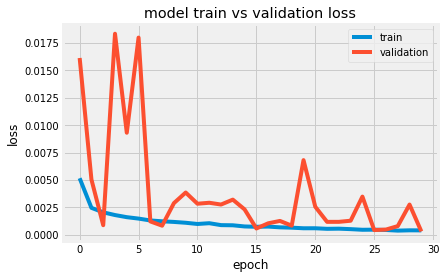

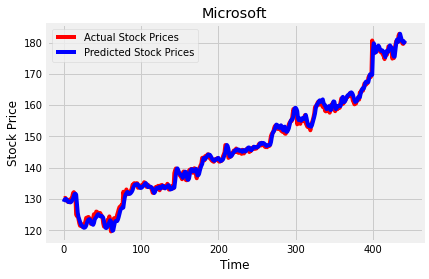

Microsoft Root Mean Squared Error: 1.274714266419979


In [42]:
y_true = sc.inverse_transform(test_map_y["microsoft"].reshape(-1,1)) 
y_prediction = sc.inverse_transform(lstm.predict(test_map_X["microsoft"])) 
plot_los(history)
plot(y_true, y_prediction)
rmse = sqrt(mean_squared_error(y_true, y_prediction))
print(str.capitalize("microsoft"), "Root Mean Squared Error:", rmse)

Changing the optimizer parameters didn't work, so let's try a different optimizer.

In [43]:
lstm = Sequential()
lstm.add(LSTM(units=96, return_sequences=True, input_shape=(train_map_X["microsoft"].shape[1],1)))
lstm.add(Dropout(0.2))
lstm.add(LSTM(units=32))
lstm.add(Dropout(0.2))
lstm.add(Dense(units=1))

opt = SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)

lstm.compile(optimizer=opt,loss='mean_squared_error')

# Fitting to the training set
print("Training:", "microsoft")
history = lstm.fit(train_map_X["microsoft"],train_map_y["microsoft"],epochs=30,batch_size=32,verbose=1,validation_split=0.2)

Training: microsoft
Epoch 1/30
62/62 [==============================] - 1s 19ms/step - loss: 0.0239 - val_loss: 0.1633
Epoch 2/30
62/62 [==============================] - 1s 12ms/step - loss: 0.0092 - val_loss: 0.1425
Epoch 3/30
62/62 [==============================] - 1s 14ms/step - loss: 0.0082 - val_loss: 0.1326
Epoch 4/30
62/62 [==============================] - 1s 13ms/step - loss: 0.0075 - val_loss: 0.1212
Epoch 5/30
62/62 [==============================] - 1s 13ms/step - loss: 0.0069 - val_loss: 0.1128
Epoch 6/30
62/62 [==============================] - 1s 13ms/step - loss: 0.0064 - val_loss: 0.1004
Epoch 7/30
62/62 [==============================] - 1s 13ms/step - loss: 0.0058 - val_loss: 0.0923
Epoch 8/30
62/62 [==============================] - 1s 12ms/step - loss: 0.0055 - val_loss: 0.0816
Epoch 9/30
62/62 [==============================] - 1s 12ms/step - loss: 0.0048 - val_loss: 0.0743
Epoch 10/30
62/62 [==============================] - 1s 13ms/step - loss: 0.0044 - val_lo

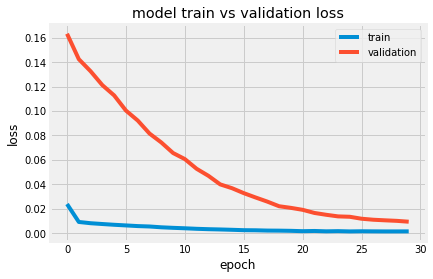

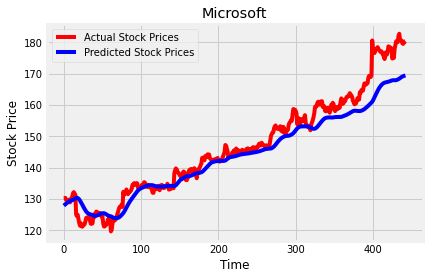

Microsoft Root Mean Squared Error: 4.903860433386552


In [44]:
y_true = sc.inverse_transform(test_map_y["microsoft"].reshape(-1,1)) 
y_prediction = sc.inverse_transform(lstm.predict(test_map_X["microsoft"])) 
plot_los(history)
plot(y_true, y_prediction)
rmse = sqrt(mean_squared_error(y_true, y_prediction))
print(str.capitalize("microsoft"), "Root Mean Squared Error:", rmse)

The SGD optimizer gave good results, but we still need to reduce the error value further, so we will make several changes to our model to get the best result.

In [73]:
lstm = Sequential()
lstm.add(LSTM(units=96, return_sequences=True, input_shape=(train_map_X["microsoft"].shape[1],1)))
lstm.add(Dropout(0.2))
lstm.add(LSTM(units=64))
lstm.add(Dropout(0.2))
lstm.add(Dense(units=1))

opt = SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)

lstm.compile(optimizer=opt,loss='mean_squared_error')

# Fitting to the training set
print("Training:", "microsoft")
history = lstm.fit(train_map_X["microsoft"],train_map_y["microsoft"],epochs=30,batch_size=32,verbose=1,validation_split=0.2)

Training: microsoft
Epoch 1/30
62/62 [==============================] - 1s 21ms/step - loss: 0.0181 - val_loss: 0.1295
Epoch 2/30
62/62 [==============================] - 1s 13ms/step - loss: 0.0070 - val_loss: 0.1185
Epoch 3/30
62/62 [==============================] - 1s 13ms/step - loss: 0.0067 - val_loss: 0.1073
Epoch 4/30
62/62 [==============================] - 1s 13ms/step - loss: 0.0062 - val_loss: 0.1006
Epoch 5/30
62/62 [==============================] - 1s 12ms/step - loss: 0.0057 - val_loss: 0.0885
Epoch 6/30
62/62 [==============================] - 1s 13ms/step - loss: 0.0052 - val_loss: 0.0861
Epoch 7/30
62/62 [==============================] - 1s 14ms/step - loss: 0.0048 - val_loss: 0.0754
Epoch 8/30
62/62 [==============================] - 1s 14ms/step - loss: 0.0044 - val_loss: 0.0692
Epoch 9/30
62/62 [==============================] - 1s 13ms/step - loss: 0.0041 - val_loss: 0.0608
Epoch 10/30
62/62 [==============================] - 1s 13ms/step - loss: 0.0038 - val_lo

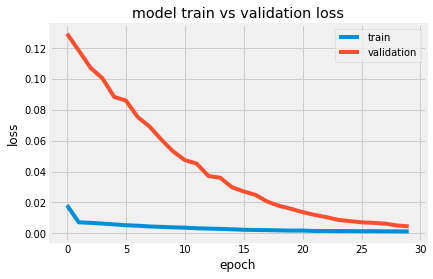

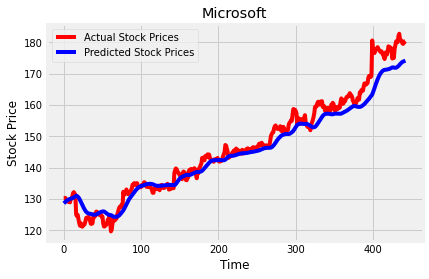

Microsoft Root Mean Squared Error: 3.714052638394449


In [74]:
y_true = sc.inverse_transform(test_map_y["microsoft"].reshape(-1,1)) 
y_prediction = sc.inverse_transform(lstm.predict(test_map_X["microsoft"])) 
plot_los(history)
plot(y_true, y_prediction)
rmse = sqrt(mean_squared_error(y_true, y_prediction))
print(str.capitalize("microsoft"), "Root Mean Squared Error:", rmse)

In [77]:
def plot_5(y_true, y_prediction):
    plt.plot(y_true, color='red', label='Actual Stock Prices')
    plt.plot(y_prediction, color='blue', label='Predicted Stock Prices')
    plt.title(str.capitalize(key))
    plt.xlabel('Time')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()

We got the best result so far now let's apply it to other stock prices.

Training:  microsoft


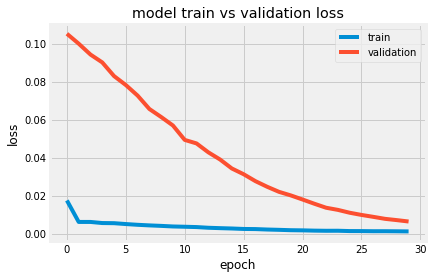

Training:  google


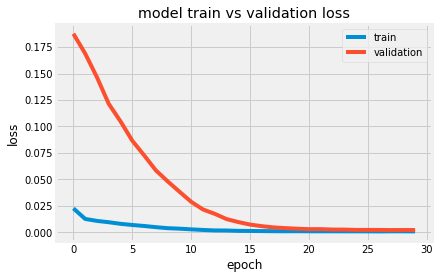

Training:  apple


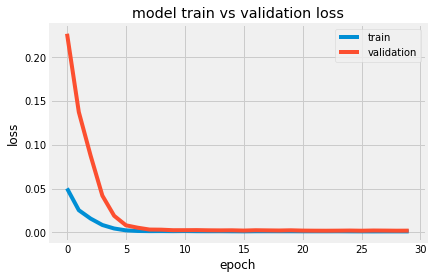

Training:  amazon


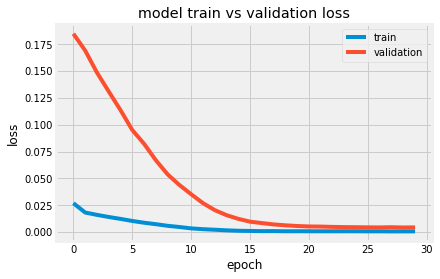

Training:  ibm


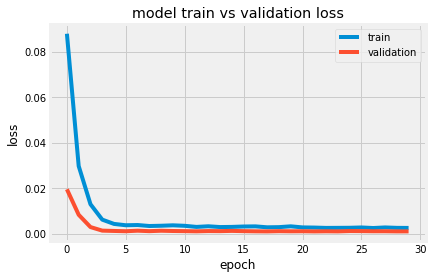

In [79]:
for key in train_map_X.keys():
    
    lstm = Sequential()
    lstm.add(LSTM(units=96, return_sequences=True, input_shape=(train_map_X[key].shape[1],1)))
    lstm.add(Dropout(0.2))
    lstm.add(LSTM(units=64))
    lstm.add(Dropout(0.2))
    lstm.add(Dense(units=1))

    opt = SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)

    lstm.compile(optimizer=opt,loss='mean_squared_error')
    print("Training: ", key)
    history = lstm.fit(train_map_X[key],train_map_y[key],epochs=30,batch_size=32,verbose=0,validation_split=0.2)
    plot_los(history)

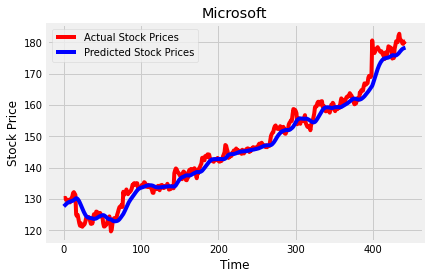

Microsoft Root Mean Squared Error: 2.6667171539016663


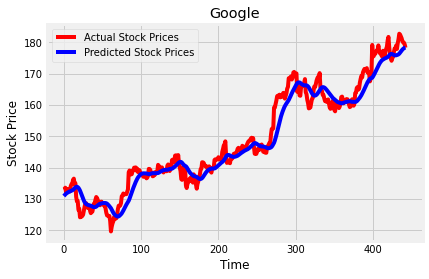

Google Root Mean Squared Error: 3.5179596917530054


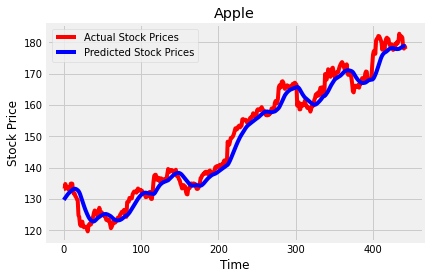

Apple Root Mean Squared Error: 3.2442349774370522


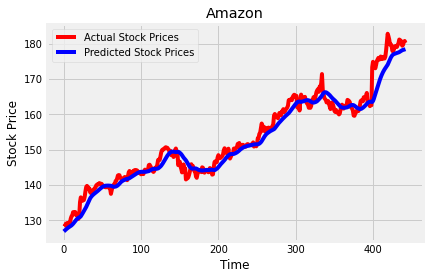

Amazon Root Mean Squared Error: 2.548567993998187


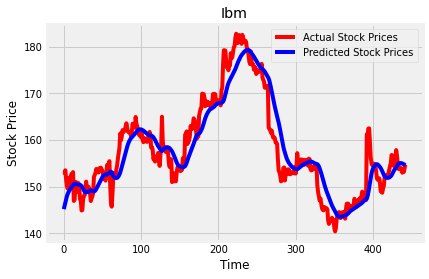

Ibm Root Mean Squared Error: 3.8477722433619634


In [80]:
for key in test_map_X.keys():
    y_true = sc.inverse_transform(test_map_y[key].reshape(-1,1)) 
    y_prediction = sc.inverse_transform(lstm.predict(test_map_X[key]))   
    plot_5(y_true, y_prediction)
    rmse = sqrt(mean_squared_error(y_true, y_prediction))
    print(str.capitalize(key), "Root Mean Squared Error:", rmse)

## Training with GRU

GRU is computationally easier than LSTM since it has only 2 gates. GRU use less training parameters and therefore use less memory, execute faster and train faster than LSTM's whereas LSTM is more accurate on dataset using longer sequence. In short, if sequence is large or accuracy is very critical, LSTM is better whereas for less memory consumption and faster operation GRU is better.

Training:  microsoft


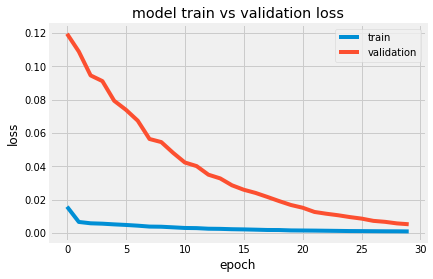

Training:  google


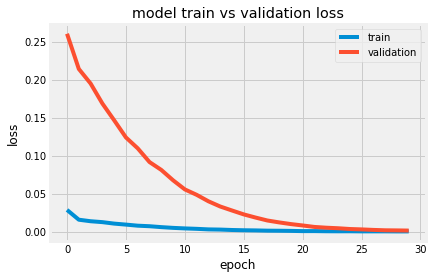

Training:  apple


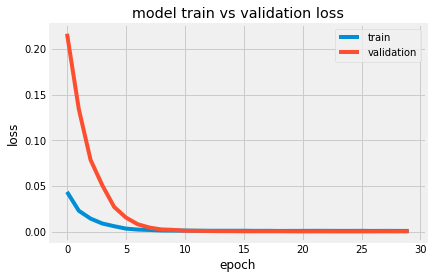

Training:  amazon


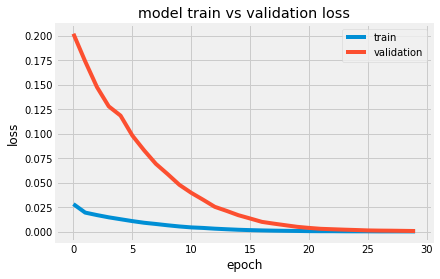

Training:  ibm


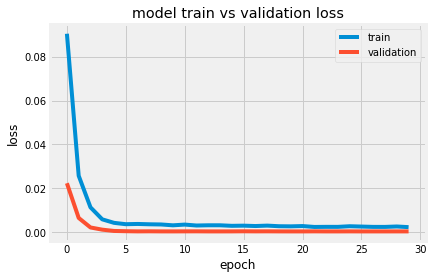

In [81]:
for key in train_map_X.keys():
    
    gru = Sequential()
    gru.add(GRU(units=96, return_sequences=True, input_shape=(train_map_X[key].shape[1],1)))
    gru.add(Dropout(0.2))
    gru.add(GRU(units=64))
    gru.add(Dropout(0.2))
    gru.add(Dense(units=1))

    opt = SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)

    gru.compile(optimizer=opt,loss='mean_squared_error')
    print("Training: ", key)
    history = gru.fit(train_map_X[key],train_map_y[key],epochs=30,batch_size=32,verbose=0,validation_split=0.2)
    plot_los(history)

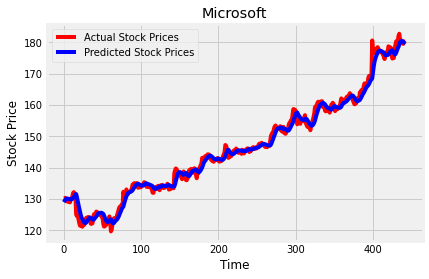

Microsoft Root Mean Squared Error: 1.704226770270261


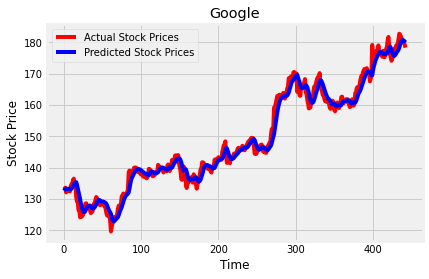

Google Root Mean Squared Error: 2.2377121776329143


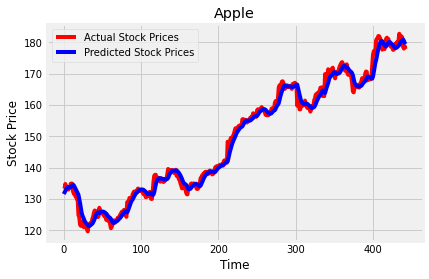

Apple Root Mean Squared Error: 1.9150344690851506


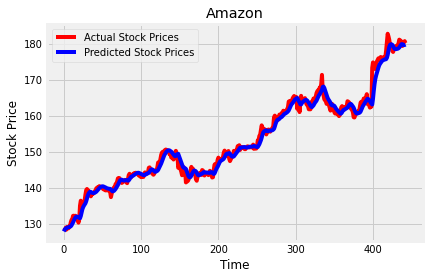

Amazon Root Mean Squared Error: 1.5710441606407293


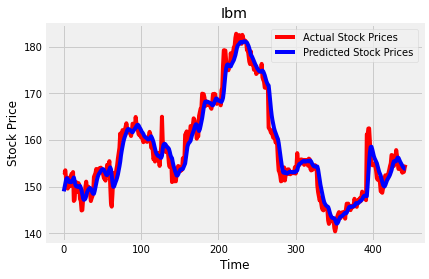

Ibm Root Mean Squared Error: 2.430349079063256


In [82]:
for key in test_map_X.keys():
    y_true = sc.inverse_transform(test_map_y[key].reshape(-1,1)) 
    y_prediction = sc.inverse_transform(gru.predict(test_map_X[key]))   
    plot_5(y_true, y_prediction)
    rmse = sqrt(mean_squared_error(y_true, y_prediction))
    print(str.capitalize(key), "Root Mean Squared Error:", rmse)


GRU gave better results for both processed time and prediction value.